# Projet Data Science Livrable 3


GROUPE : 
- Ali RAMDANI
- Nariman FOUGHALI
- Meriem HAMOUMA
- Aissa HADJ ARAB


Ce projet a traité à la création d'un système de génération de légende pour des images utilisant l'apprentissage en profondeur. Nous avons utilisé un ensemble de données d'images et de légendes pour entraîner un modèle basé sur le réseau de neurones pour générer des légendes pour des images spécifiques. Le modèle utilise une combinaison d'un encoder CNN pour extraire les caractéristiques de l'image, un décodeur RNN pour générer la légende, et une attention pour sélectionner les zones importantes de l'image lors de la génération de la légende. Nous avons également implémenté une fonctionnalité d'attention pour visualiser les zones de l'image qui ont été considérées comme importantes lors de la génération de la légende. Enfin, un système de sauvegarde de point de contrôle a été mis en place pour sauvegarder l'état du modèle pendant l'entraînement.

# Etape 1 : Importation des librairies

Ce code importe les bibliothèques tensorflow, sklearn, glob, PIL, tqdm, matplotlib et numpy pour être utilisées dans le projet.
Les bibliothèques tensorflow et sklearn sont utilisées pour construire et entraîner un modèle de machine learning.
La bibliothèque glob est utilisée pour trouver tous les fichiers correspondant à un modèle donné dans un système de fichiers.
La bibliothèque PIL est utilisée pour ouvrir et manipuler des images.
La bibliothèque tqdm est utilisée pour afficher une barre de progression pour les boucles de traitement de données.
La bibliothèque matplotlib est utilisée pour créer des graphiques et des visualisations.
La bibliothèque numpy est utilisée pour travailler avec des tableaux et des matrices de données numériques.
Les bibliothèques sys, os, collections, random, re, json, time, pickle et datetime sont des bibliothèques Python standard utilisées pour diverses tâches, telles que la gestion des systèmes de fichiers, la manipulation de chaînes de caractères, la manipulation de données JSON, et la manipulation de dates et d'horaires.

In [1]:
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from glob import glob
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import sys , os , collections ,random , re , json , time , pickle , datetime

# Etape 2 : Importation des données

Cette fonction vérifie la disponibilité d'une carte GPU sur l'ordinateur en cours d'utilisation et configure l'accélération GPU pour TensorFlow si elle est disponible.
La fonction utilise la fonction tf.config.experimental.list_physical_devices('GPU') pour vérifier s'il y a une carte GPU présente sur l'ordinateur. Si une carte GPU est détectée, la fonction imprime un message indiquant que la GPU est disponible et affiche les détails de la carte GPU. Sinon, elle imprime un message indiquant que la GPU n'est pas disponible et affiche les détails des périphériques physiques présents sur l'ordinateur.
La fonction utilise ensuite la fonction tf.config.experimental.set_memory_growth (gpu, True) pour permettre à TensorFlow de croître de manière dynamique en utilisant seulement l'espace mémoire nécessaire, ce qui permet de maximiser l'utilisation de la mémoire GPU.
Enfin, il y a des print pour indiquer l'état de la GPU. 

In [2]:
def prepare_gpu_acceleration():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        print("GPU is AVAILABLE 🚀")
        print(tf.config.experimental.list_physical_devices('GPU'))
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print("An error occured while setting memory growth for GPU 💀")
            print(e)
    else:
        print("GPU is NOT AVAILABLE 🐌")
        print(tf.config.experimental.list_physical_devices())

prepare_gpu_acceleration()

GPU is AVAILABLE 🚀
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Ces lignes de code définissent le chemin d'accès au dossier de annotations et au fichier de annotations pour les images utilisées pour l'entraînement.
La variable annotation_folder contient le chemin d'accès au dossier où les annotations des images sont stockées.
La variable annotation_file utilise la fonction os.path.abspath() pour obtenir le chemin absolu de l'emplacement actuel de l'exécution du script, puis ajoute le chemin d'accès relatif au fichier de annotations pour obtenir le chemin absolu complet vers le fichier de annotations pour les images d'entraînement.

In [3]:
# chemin du ficher json contenant les annotations
annotation_folder = "/annotations/"
annotation_file = os.path.abspath(".")+"/annotations/captions_train2014.json"

Ces lignes de code définissent le chemin d'accès au dossier contenant les images utilisées pour l'annotation.
La variable image_folder contient le chemin d'accès relatif au dossier contenant les images à annoter.
La variable PATH utilise la fonction os.path.abspath() pour obtenir le chemin absolu de l'emplacement actuel de l'exécution du script, puis ajoute le chemin d'accès relatif au dossier des images pour obtenir le chemin absolu complet vers le dossier des images utilisées pour l'annotation.

In [4]:
# chemin du dossier contenant les images a annoter
image_folder = "/train2014/"
PATH = os.path.abspath(".")+ image_folder

# Etape 2 : Prétraitement des données

Ces lignes de code chargent les annotations des images dans un dictionnaire Python en utilisant la bibliothèque json.
La fonction open() est utilisée pour ouvrir le fichier de annotations spécifié par la variable annotation_file en mode lecture ('r'). Le contenu du fichier est ensuite chargé dans une variable f.
La fonction json.load() est utilisée pour lire les données JSON du fichier ouvert en utilisant la variable f, puis les charger dans une variable annotations qui est un dictionnaire Python.
Cette étape permet de charger les annotations des images dans le script pour pouvoir y accéder et les utiliser pour l'entraînement du modèle.

In [5]:
# lecture du fichier d'annotations
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

Ces lignes de code regroupent les annotations pour chaque image en utilisant un dictionnaire de collections par défaut.
La variable image_path_to_caption est déclarée comme un dictionnaire de collections par défaut qui regroupe les annotations pour chaque image en utilisant le chemin d'accès de l'image comme clé.
La boucle for parcoure les annotations dans le dictionnaire annotations et pour chaque annotation, une nouvelle variable caption est créée en ajoutant les balises de début et de fin <start> et <end> pour marquer le début et la fin de la légende.
La variable image_path est ensuite créée en ajoutant le chemin d'accès absolu vers le dossier des images à l'identifiant de l'image pour obtenir le chemin d'accès complet vers l'image correspondante.
Enfin, la variable caption est ajoutée à la liste des légendes pour l'image correspondante en utilisant le image_path comme clé dans le dictionnaire image_path_to_caption.
Cette étape permet de regrouper les annotations pour chaque image de manière à les utiliser pour l'entraînement du modèle de génération de légende.

In [6]:
# Grouper toutes les annotations pour chaque image  
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

Ces lignes de code préparent les chemins d'accès aux images pour l'entraînement en les mélangeant aléatoirement et en sélectionnant un sous-ensemble des chemins d'accès les plus pertinents.
La variable image_paths est définie comme une liste des clés du dictionnaire image_path_to_caption, qui sont les chemins d'accès aux images avec des annotations.
La fonction random.shuffle() est utilisée pour mélanger aléatoirement les chemins d'accès aux images.
La variable train_image_paths est ensuite définie comme les premiers 10000 chemins d'accès mélangés, qui seront utilisés pour l'entraînement du modèle.
La fonction len() est utilisée pour imprimer le nombre de chemins d'accès sélectionnés pour l'entraînement.
Cette étape permet de sélectionner un sous-ensemble des images les plus pertinents pour l'entraînement, en les mélangeant aléatoirement pour éviter tout biais dans les données d'entraînement.

Un biais : (ou "biais algorithmique") est une tendance systématique dans les résultats d'un modèle en raison d'une sélection inappropriée ou d'une préparation des données. En d'autres termes, un biais se produit lorsque les données d'entraînement utilisées pour entraîner un modèle ne sont pas représentatives de l'ensemble des données sur lesquelles le modèle sera utilisé. Cela peut entraîner des résultats incorrects ou inexacts lorsque le modèle est utilisé pour des données réelles qui ne correspondent pas aux données d'entraînement.
En mélangeant les données d'entraînement aléatoirement, on évite que les modèles ne soient entraînés sur des sous-ensembles de données qui pourraient causer un biais.

In [7]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)
# selectionner les 10000 premiers chemins d'images
# Chaque image a environ 5 annotations, donc on va avoir 50000 exemples
# On va donc diviser les 50000 exemples en 2 parties, 40000 pour l'entrainement et 10000 pour le test
train_image_paths = image_paths[:10000]
print(len(train_image_paths))


10000


Ces lignes de code préparent les légendes et les images pour l'entraînement en créant des listes de légendes et de noms d'images associés.
Les variables train_captions et img_name_vector sont déclarées comme des listes vides qui seront utilisées pour stocker les légendes d'entraînement et les noms d'images associés.
La boucle for parcourt les chemins d'accès aux images dans la variable train_image_paths et pour chaque chemin d'accès, la variable caption_list est définie en récupérant les légendes associées à l'image en utilisant le chemin d'accès de l'image comme clé dans le dictionnaire image_path_to_caption.
Les légendes récupérées sont ensuite étendues à la liste train_captions.
La variable img_name_vector est ensuite étendue pour ajouter le nom de l'image autant de fois que le nombre de légendes associées à l'image.
Cette étape permet de créer des listes de légendes et de noms d'images pour l'entraînement du modèle de génération de légende.

In [8]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> a picture of an old boat with a lot of people around it <end>


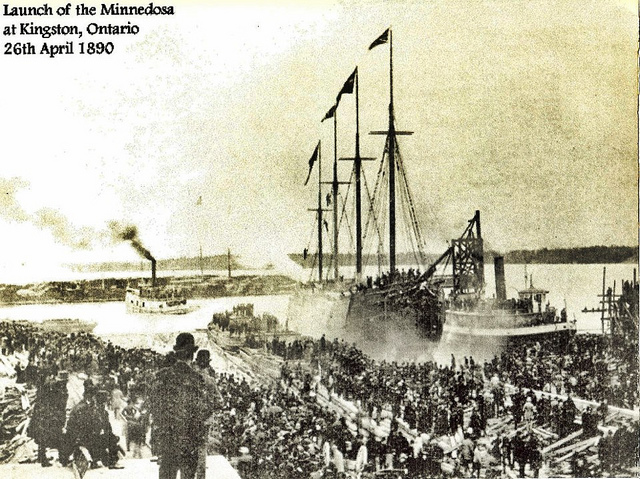

In [9]:
# afficher la liste de légendes train_captions et la première image de la liste de noms d'images img_name_vector.
# Cela permet de vérifier que les légendes et les images sont correctement associées et prêtes pour l'entraînement.

# return string : affiche la première légende de la liste train_captions
print(train_captions[0])
# return image (PIL.Image.Image) : affiche la première image de la liste img_name_vector
Image.open(img_name_vector[0])

Cette fonction charge une image à partir d'un chemin d'accès donné en utilisant les fonctions de lecture et de décodage de TensorFlow.
La fonction prend en entrée un chemin d'accès à une image (image_path) et utilise la fonction tf.io.read_file(image_path) pour lire le contenu de l'image à partir de son emplacement sur le disque.

La fonction tf.io.decode_jpeg(img, channels=3) est utilisée pour décoder les données de l'image en un tableau numpy avec 3 canaux (RGB)
La fonction tf.keras.layers.Resizing(299, 299)(img) permet de redimensionner l'image à (299, 299) pixels.
La fonction tf.keras.applications.inception_v3.preprocess_input(img) prétraite l'image en normalisant les valeurs de pixels pour être compatibles avec les entrées attendues par le modèle InceptionV3.

Enfin,la fonction retourne les images ainsi que le chemin d'accès à l'image (image_path) sous forme de tuple (img, image_path) pour pouvoir être utilisées ultérieurement.
Cette fonction permet de charger une image à partir d'un chemin d'accès donné, de la redimensionner, de la prétraiter et de la retourner sous forme de tableau numpy compatible avec le modèle InceptionV3. Cela permet de préparer les images pour l'entraînement du modèle de génération de légende.

In [10]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

Ces lignes de code utilisent le modèle InceptionV3 pré-entraîné pour extraire les caractéristiques des images.
La variable image_model est définie en utilisant la fonction tf.keras.applications.InceptionV3() pour charger le modèle pré-entraîné InceptionV3. Les paramètres include_top=False et weights='imagenet' sont utilisés pour ne pas inclure les couches de classification de l'image et pour charger les poids pré-entraînés sur l'ensemble de données ImageNet.

La variable new_input est définie en utilisant l'entrée du modèle image_model.
La variable hidden_layer est définie en utilisant la dernière couche cachée du modèle image_model.
La variable image_features_extract_model est ensuite définie en utilisant la fonction tf.keras.Model() en utilisant new_input comme entrée et hidden_layer comme sortie.

Cela permet de créer un nouveau modèle qui prend une image en entrée et renvoie les caractéristiques de l'image extraites à partir de la dernière couche cachée du modèle InceptionV3. Ce nouveau modèle sera utilisé pour extraire les caractéristiques des images avant de les utiliser pour l'entraînement du modèle de génération de légende.

In [11]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

Ces lignes de code utilisent le modèle précédemment créé pour extraire les caractéristiques des images d'entraînement.

La variable encode_train est définie en utilisant la fonction sorted() pour trier la liste img_name_vector de chemins d'accès aux images d'entraînement, et la fonction set() pour éliminer les doublons.

La variable image_dataset est ensuite définie en utilisant la fonction tf.data.Dataset.from_tensor_slices() pour créer un dataset à partir des chemins d'accès aux images triés et sans doublons.

La fonction map() est utilisée pour appliquer la fonction load_image() à chaque élément du dataset et le paramètre num_parallel_calls=tf.data.AUTOTUNE est utilisé pour améliorer les performances en parallélisant le traitement. 

La fonction batch(16) est utilisée pour regrouper les éléments en lots de 16.

La boucle for parcourt les images du dataset et utilise le modèle image_features_extract_model pour extraire les caractéristiques de chaque image dans un lot. 

La fonction tf.reshape() est utilisée pour redimensionner les caractéristiques extraites pour qu'elles aient la forme (batch_size, -1, nombre de canaux) pour pouvoir être enregistrées en utilisant la fonction np.save().

La variable path_of_feature est définie en utilisant la fonction numpy().decode("utf-8") pour décoder le chemin d'accès à l'image en une chaîne de caractères. 

La fonction np.save(path_of_feature, bf.numpy()) enregistre alors les caractéristiques extraites de l'image dans un fichier numpy à l'emplacement spécifié par path_of_feature.

Ces lignes de code permettent d'extraire les caractéristiques des images d'entraînement en utilisant le modèle InceptionV3 pré-entraîné et en les enregistrant sous forme de fichiers numpy pour une utilisation ultérieure dans l'entraînement du modèle de génération de légende.

In [12]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

Ces lignes de code utilisent les légendes d'entraînement pour créer un vocabulaire utilisé pour encoder les légendes en séquences de nombres entiers pour l'entraînement du modèle de génération de légende.

La variable caption_dataset est définie en utilisant la fonction tf.data.Dataset.from_tensor_slices() pour créer un dataset à partir de la liste de légendes d'entraînement train_captions.

La fonction standardize() est définie pour normaliser les légendes en les passant en minuscules et en remplaçant tous les caractères spéciaux par des espaces vides. Cette fonction est utilisée pour préparer les légendes avant de les encoder en séquences de nombres entiers.

La variable max_length est définie pour spécifier la longueur maximale d'une légende, et la variable vocabulary_size est définie pour spécifier la taille du vocabulaire utilisé pour encoder les légendes.

La variable tokenizer est ensuite définie en utilisant la classe tf.keras.layers.TextVectorization pour créer un tokenizer qui utilise les paramètres spécifiés pour encoder les légendes en séquences de nombres entiers.

La méthode adapt() est utilisée pour apprendre le vocabulaire à partir des données de légendes dans le dataset caption_dataset.


Ces lignes de code permettent de préparer les légendes pour l'entraînement en les normalisant, en définissant la longueur maximale et la taille du vocabulaire, et en les encodant en séquences de nombres entiers pour être utilisées comme entrées pour le modèle de génération de légende.

In [13]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 50
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

Cette ligne de code utilise la méthode map() pour appliquer la fonction tokenizer à chaque élément du dataset de légendes caption_dataset pour créer des vecteurs tokenisés. La fonction anonyme lambda lambda x: tokenizer(x) est utilisée pour appliquer le tokenizer à chaque élément du dataset. Les légendes sont maintenant encodées en séquences de nombres entiers et prêtes pour être utilisées dans l'entraînement du modèle de génération de légende !

In [14]:
# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

Ces lignes de code créent les mappages entre les mots et les indices (word_to_index) et les indices et les mots (index_to_word) pour les séquences tokenisées.

Les variables word_to_index et index_to_word sont définies en utilisant la classe tf.keras.layers.StringLookup qui permet de convertir des mots en indices et des indices en mots. 

Le paramètre mask_token est défini sur "" pour ne pas masquer de tokens. 
Le paramètre vocabulary est défini en utilisant la méthode get_vocabulary() pour récupérer le vocabulaire appris précédemment. 
Le paramètre invert est défini sur True pour index_to_word pour inverser les mappages.


Ces mappages permettent de faciliter la génération de légendes en utilisant des indices pour représenter des mots et en les convertissant en mots pour l'affichage.

In [15]:
# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

Ces lignes de code utilisent les images et les vecteurs de légendes tokenisées pour créer des ensembles d'entraînement et de validation pour l'entraînement du modèle de génération de légende.
La variable img_to_cap_vector est définie en utilisant la boucle for pour regrouper les vecteurs tokenisés de légendes pour chaque image.
Les images sont ensuite mélangées aléatoirement en utilisant la fonction random.shuffle() et divisées en ensembles d'entraînement et de validation en utilisant une proportion 80-20.
La boucle for est utilisée pour regrouper les images et les vecteurs tokenisés de légendes pour les ensembles d'entraînement et de validation. Les variables img_name_train et cap_train contiendront les images et les vecteurs tokenisés de légendes pour l'ensemble d'entraînement, et les variables img_name_val et cap_val contiendront les images et les vecteurs tokenisés de légendes pour l'ensemble de validation. 


Ces ensembles seront utilisés pour entraîner et évaluer le modèle de génération de légendes.

Il est important de noter que pour chaque image, il y a plusieurs légendes associées. Ces lignes de code permettent de regrouper toutes les légendes associées à une image et de les utiliser pour entraîner le modèle.
En résumé, ces lignes de code permettent de créer des ensembles d'entraînement et de validation pour l'entraînement du modèle de génération de légende en utilisant les images et les vecteurs tokenisés de légendes précédemment créés et en les divisant aléatoirement en utilisant une proportion 80-20.

In [16]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])


Il est important de vérifier que les longueurs des listes sont correctes pour s'assurer que les ensembles d'entraînement et de validation ont été créés correctement.

La longueur des listes img_name_train et cap_train devrait correspondre, car ces listes contiennent les images et les vecteurs tokenisés de légendes pour l'ensemble d'entraînement. 

La même chose est vraie pour les listes img_name_val et cap_val, qui contiennent les images et les vecteurs tokenisés de légendes pour l'ensemble de validation.

In [17]:
# Afficher la longueur des listes qui contiennent les images et les vecteurs tokenisés de légendes pour les ensembles d'entraînement et de validation. 

print("img_name_train = ", len(img_name_train))
print("cap_train = ", len(cap_train))
print("img_name_val = ", len(img_name_val))
print("cap_val = ", len(cap_val))

img_name_train =  40021
cap_train =  40021
img_name_val =  10004
cap_val =  10004


# Etape 3 : Création du modèle de génération de légende

Ces lignes de code définissent des variables de configuration pour l'entraînement du modèle de génération de légende.

- BATCH_SIZE est la taille des lots utilisés pour l'entraînement du modèle. Plus le nombre de lots est élevé, plus l'entraînement sera rapide, mais il y aura également un risque de surapprentissage.

- BUFFER_SIZE est la taille du tampon utilisé pour mélanger les données d'entraînement avant de les utiliser pour l'entraînement. Plus le tampon est grand, plus les données seront mélangées, ce qui peut améliorer la performance du modèle.

- embedding_dim est la dimension de l'espace de représentation des mots. Cette valeur détermine la taille de la couche d'embedding utilisée pour représenter les mots dans le modèle.

- units est le nombre de neurones utilisés pour la couche LSTM (Long Short-Term Memory) utilisée dans le modèle. Plus le nombre de neurones est élevé, plus le modèle peut stocker de mémoire à court terme, mais cela augmente également la complexité du modèle.

- features_shape est la dimension de l'espace de représentation des images. Cette valeur démine la taille de la couche de fonctionnalités d'images utilisée pour représenter les images dans le modèle. Elle est généralement définie en fonction de la taille de la sortie de la couche précédente qui extrait les fonctionnalités d'images.

- attention_features_shape est la dimension de l'espace de représentation des features d'attention. Cette valeur détermine la taille de la couche d'attention utilisée pour sélectionner les fonctionnalités importantes dans les images pour générer la légende.
En résumé, ces variables de configuration définissent les paramètres clés pour l'entraînement du modèle de génération de légende, tels que la taille des lots, la taille du tampon, la dimension de l'espace de représentation des mots et des images, et le nombre de neurones utilisés pour les couches LSTM et d'attention. Ces valeurs peuvent être ajustées pour améliorer les performances du modèle.

In [18]:
BATCH_SIZE = 64 # taille des batchs
BUFFER_SIZE = 1000 # taille du buffer
embedding_dim = 256 # dimension de l'espace de representation des mots
units = 512 # nombre de neurones de la couche LSTM
# vocab_size = top_k + 1 # taille du dictionnaire
num_steps = len(img_name_train) // BATCH_SIZE # nombre de batchs par epoch
features_shape = 2048 # dimension de l'espace de representation des images
attention_features_shape = 64 # dimension de l'espace de representation des features d'attention

Cette fonction map_func est utilisée pour charger les fichiers numpy qui contiennent les fonctionnalités d'images pour chaque image dans les ensembles d'entraînement et de validation. 

Elle prend en entrée le nom de l'image et la légende correspondante, charge le fichier numpy correspondant à l'image en utilisant np.load() en utilisant l'adresse de l'image pour construire le nom du fichier. 

Elle retourne ensuite le tenseur de fonctionnalités d'images ainsi que la légende correspondante. 

Cette fonction sera utilisée pour créer des ensembles de données pour l'entraînement et la validation qui sont synchronisés entre les images et les légendes.


In [19]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

Ces lignes de code utilisent les fonctionnalités de TensorFlow pour créer un ensemble de données à partir des images et des légendes de l'ensemble d'entraînement, puis charger les fonctionnalités d'images en utilisant la fonction map_func définie précédemment.

La première ligne crée un ensemble de données à partir des listes img_name_train et cap_train.

La fonction map est ensuite utilisée pour appliquer la fonction map_func à chaque élément de l'ensemble de données, en utilisant tf.numpy_function pour exécuter la fonction map_func dans un contexte numpy. Le nombre de travaux parallèles est défini en utilisant num_parallel_calls=tf.data.AUTOTUNE, ce qui permet à TensorFlow de choisir automatiquement le nombre optimal de travaux parallèles pour charger les fichiers numpy.

Ensuite, les données sont mélangées aléatoirement en utilisant shuffle(BUFFER_SIZE) pour briser toute séquence éventuelle dans les données, puis regroupées en lots en utilisant batch(BATCH_SIZE).

Finalement, prefetch est utilisé pour précharger les données suivantes dans un tampon en arrière-plan, ce qui permet de réduire les temps d'attente lors de l'entraînement du modèle. Cela améliore les performances en s'assurant que les données suivantes sont déjà prêtes pour être utilisées par le modèle lorsque le modèle est prêt à les utiliser, plutôt que de les charger lorsque le modèle les demande.

Ces étapes de prétraitement permettent de créer un ensemble de données synchronisé entre les images et les légendes, qui peut être utilisé pour entraîner le modèle de génération de légende. La même logique est utilisée pour créer un ensemble de données de validation à partir de img_name_val et cap_val.


In [20]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

Cette classe définit un modèle d'attention appelé BahdanauAttention. Il utilise l'attention séquentielle pour décider de l'importance de chaque feature d'image pour générer une légende pour une image donnée. Il est utilisé dans le modèle de génération de légende pour sélectionner les features d'image pertinents pour générer une légende pour une image donnée.

L'attention est un mécanisme qui permet de sélectionner des sous-parties d'une entrée pour une tâche donnée. 
Il est utilisé pour sélectionner les sous-parties d'une image qui sont pertinentes pour générer une légende pour cette image.

Le modèle est initialisé en utilisant les couches Dense, qui sont des couches de réseau neuronal fully-connected. Les couches W1 et W2 sont utilisées pour produire une réprésentation de la séquence d'images, tandis que la couche V est utilisée pour produire un score pour chaque élément de la séquence.

La fonction call est utilisée pour appeler le modèle avec les features d'images et les hidden states en entrée, et retourne le context_vector et les attention_weights en sortie. Le context_vector est utilisé pour générer la légende, tandis que les attention_weights sont utilisés pour visualiser les parties de l'image qui ont été sélectionnées pour générer la légende.


In [21]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

La classe CNN_Encoder définit un encoder basé sur un réseau de neurones convolutionnel (CNN) qui transforme les features extraits d'une image en une représentation dense de dimension embedding_dim. Il est utilisé pour convertir les features d'image extraits en une représentation dense pour la génération de légende.

La fonction d'initialisation de la classe prend en paramètre la dimension de l'espace de représentation des mots (embedding_dim). Il crée une couche Dense, qui est une couche de réseau neuronal fully-connected, utilisée pour produire une réprésentation dense des features d'image.

La fonction call est utilisée pour appeler l'encoder avec les features d'image en entrée, et retourne la réprésentation dense des features en sortie. Cette réprésentation est utilisée comme entrée pour la génération de légende.





In [22]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

La fonction RNN_Decoder est un modèle qui décode les vecteurs d'images encodés en une séquence de mots. Elle utilise un modèle de réseau de neurones récurrent (GRU) pour générer une séquence de mots à partir d'un vecteur d'image encodé et d'un vecteur de contexte qui est obtenu en utilisant une attention de Bahdanau. Elle a trois couches principales:

- L'embedding: qui permet de convertir les mots en vecteurs de mots de dimensions embedding_dim
- La couche GRU: qui utilise les vecteurs d'images encodés et les vecteurs de contexte pour générer une séquence de mots
- Les couches fully connected: qui permettent de produire la sortie finale qui est la prédiction de la séquence de mots.

Il y a aussi une classe BahdanauAttention qui permet de calculer le vecteur de contexte en utilisant l'attention de Bahdanau.
La méthode call() permet de décoder l'image en utilisant l'image encodée, les features et le hidden state. Il retourne la prédiction de la séquence de mots, l'état caché et les poids d'attention.

La méthode reset_state() permet de réinitialiser l'état caché à zéro pour chaque batch.





In [23]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

L'encoder CNN_Encoder et le décodeur RNN_Decoder ont été créés avec les paramètres spécifiés : la dimension d'incorporation, les unités et la taille du vocabulaire pour chacun d'eux. 

- L'encoder passe les caractéristiques de l'image à travers une couche fully connected et renvoie l'espace de représentation des images.

- Le décodeur utilise l'attention de Bahdanau pour sélectionner les caractéristiques les plus pertinentes de l'image pour générer les sous-titres en utilisant une combinaison de l'espace de représentation de l'image et de l'état caché. Il renvoie également les poids d'attention pour chaque image.

In [24]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

# Etape 4 : Entraînement du modèle

La fonction de perte loss_function calcule la perte pour chaque exemple de la séquence en utilisant la fonction SparseCategoricalCrossentropy. Cette fonction prend en entrée les étiquettes réelles (real) et les prédictions (pred), et renvoie la perte pour chaque exemple. La perte est ensuite masquée en utilisant un masque qui indique les éléments de la séquence qui ne sont pas des tokens de remplissage (0). La perte masquée est ensuite réduite en moyenne pour obtenir une valeur de perte globale pour l'ensemble de la séquence. Cette fonction de perte est utilisée pour entraîner le modèle en minimisant la divergence entre les étiquettes réelles et les prédictions.

In [25]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

Le code ci-dessus met en place un système de point de contrôle pour enregistrer l'état du modèle pendant l'entraînement. La variable checkpoint_path spécifie le répertoire où les fichiers de point de contrôle seront enregistrés, avec la date et l'heure courantes incluses dans le nom de fichier. 

La variable ckpt est une instance de la classe tf.train.Checkpoint, qui est utilisée pour enregistrer et restaurer les variables du modèle (dans ce cas, l'encodeur, le décodeur et l'optimiseur). 

La variable ckpt_manager est une instance de la classe tf.train.CheckpointManager, qui est utilisée pour gérer les fichiers de point de contrôle, spécifiquement le chemin de point de contrôle est spécifié, et le nombre maximum de points de contrôle à conserver est défini à 5.Cela signifie que seuls les cinq derniers fichiers de point de contrôle seront conservés.





In [26]:
checkpoint_path = "./checkpoints/train" + f"_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"

ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
                           
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

Ce code vérifie s'il existe un dernier point de contrôle dans le répertoire spécifié par checkpoint_path. S'il en existe un, la variable start_epoch est définie sur le numéro de l'époque de ce point de contrôle (extraite du nom de fichier du point de contrôle). Ensuite, en utilisant la méthode restore de ckpt, le dernier point de contrôle est chargé pour continuer la formation à partir de l'époque où elle s'est arrêtée.





In [27]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

Le code ci-dessus crée une liste vide qui sera utilisée pour stocker les valeurs de la perte au cours de l'entraînement. Cette liste sera utilisée plus tard pour tracer l'évolution de la perte au fil du temps et suivre la performance de l'entraînement.





In [28]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

La fonction train_step ci-dessus permet de former un pas de modèle. Elle prend en entrée un tenseur d'image et un tenseur cible (c'est-à-dire les sous-titres associés à cette image). 

Elle initialise d'abord l'état caché pour chaque lot, car les légendes ne sont pas liées d'une image à l'autre.

Elle utilise ensuite l'entrée de décodeur pour passer les caractéristiques de l'encodage de l'image à travers le décodeur.
 
La boucle for itère sur chaque mot du sous-titre cible, en utilisant la technique de "teacher forcing" pour fournir la réponse attendue au décodeur à chaque étape. 
  
La perte totale est ensuite calculée en divisant la somme des pertes par la longueur du sous-titre cible. 

Les gradients sont ensuite calculés par rapport aux variables d'entraînement (encoder et décodeur) et utilisés pour mettre à jour les paramètres du modèle en utilisant l'optimiseur. 

La fonction retourne également la perte totale pour chaque image.

In [31]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

Ce code ci-dessus est utilisé pour entraîner le modèle sur les données d'entraînement.

 Il utilise une boucle pour parcourir les époques (EPOCHS) et une autre boucle pour parcourir les batchs de données. Pour chaque batch, la fonction train_step est appelée pour mettre à jour les poids du modèle en utilisant les données de ce batch. 
 
 La perte pour chaque batch est calculée et stockée dans la variable batch_loss. 
 
 La perte totale pour chaque époque est calculée en additionnant toutes les pertes de batch et stockée dans la variable total_loss. Après chaque époque, la perte moyenne pour cette époque est enregistrée dans la liste loss_plot pour une visualisation ultérieure. 
 
 Si l'époque actuelle est un multiple de 5, le modèle est enregistré en utilisant ckpt_manager. 
 
 Enfin, le temps pris pour chaque époque est affiché.

In [32]:
EPOCHS = 50

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 1.8605
Epoch 1 Batch 100 Loss 1.0610
Epoch 1 Batch 200 Loss 0.9004
Epoch 1 Batch 300 Loss 0.8622
Epoch 1 Batch 400 Loss 0.6976
Epoch 1 Batch 500 Loss 0.7360
Epoch 1 Batch 600 Loss 0.8218
Epoch 1 Loss 0.921353
Time taken for 1 epoch 174.05 sec

Epoch 2 Batch 0 Loss 0.7653
Epoch 2 Batch 100 Loss 0.7614
Epoch 2 Batch 200 Loss 0.7503
Epoch 2 Batch 300 Loss 0.7198
Epoch 2 Batch 400 Loss 0.6748
Epoch 2 Batch 500 Loss 0.6585
Epoch 2 Batch 600 Loss 0.6432
Epoch 2 Loss 0.718397
Time taken for 1 epoch 104.50 sec

Epoch 3 Batch 0 Loss 0.6812
Epoch 3 Batch 100 Loss 0.6837
Epoch 3 Batch 200 Loss 0.6503
Epoch 3 Batch 300 Loss 0.6372
Epoch 3 Batch 400 Loss 0.6117
Epoch 3 Batch 500 Loss 0.6096
Epoch 3 Batch 600 Loss 0.6647
Epoch 3 Loss 0.660688
Time taken for 1 epoch 112.96 sec

Epoch 4 Batch 0 Loss 0.6200
Epoch 4 Batch 100 Loss 0.6211
Epoch 4 Batch 200 Loss 0.5686
Epoch 4 Batch 300 Loss 0.6424
Epoch 4 Batch 400 Loss 0.5947
Epoch 4 Batch 500 Loss 0.6359
Epoch 4 Batch 600 Loss 0.62

# Etape 5 : Evaluation du modèle

Le code ci-dessus utilise la bibliothèque matplotlib pour tracer un graphique de la perte en fonction des époques. 

Le graphique affiche l'évolution de la perte au cours de l'entraînement en utilisant les données stockées dans la variable loss_plot. Les étiquettes d'axe x et y sont définies comme 'Epochs' et 'Loss' respectivement, avec un titre 'Loss Plot' pour le graphique. 

La fonction plt.show() est utilisée pour afficher le graphique à l'écran.


La perte initiale est généralement élevée, mais elle devrait diminuer au fil des époques d'entraînement. 

Si cela se produit, cela signifie que le modèle est en train d'apprendre et de s'ajuster aux données d'entraînement. 

Si la perte reste stable ou augmente, cela peut indiquer que le modèle est surajusté ou qu'il a besoin d'une plus grande quantité de données d'entraînement pour s'ajuster.

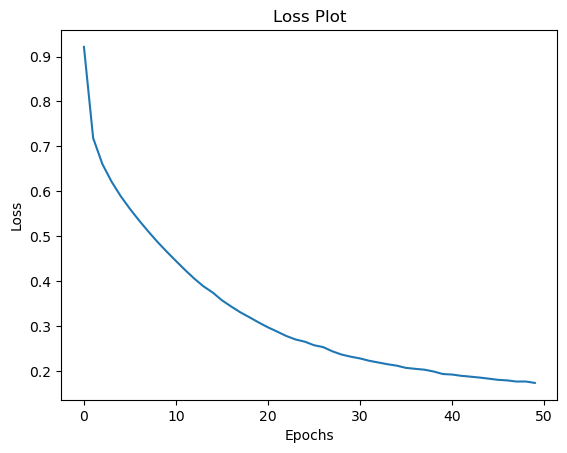

In [33]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

La fonction evaluate ci-dessus prend une image en entrée et utilise le modèle d'encodage et de décodage précédemment entraîné pour générer une description de cette image. 

Il initialise d'abord les poids d'attention à zéro et réinitialise l'état caché du décodeur. 

Il charge ensuite l'image en utilisant la fonction load_image, extrait les caractéristiques de l'image en utilisant le modèle d'extraction de caractéristiques d'images et les passe à travers le modèle d'encodage. 

Il utilise ensuite la méthode de décodage pour générer des prédictions de mots en utilisant les caractéristiques de l'image encodées et les poids d'attention. 

Il ajoute chaque mot prédit à un tableau de résultats jusqu'à ce qu'il atteigne le mot de fin ou le nombre maximum de mots autorisé dans la description. 

Il retourne également un graphique d'attention pour visualiser les caractéristiques de l'image sur lesquelles le modèle a concentré son attention pour générer la description.



In [34]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

La fonction ci-dessus permet de tracer l'attention en utilisant matplotlib. Elle prend en entrée une image, un résultat (une phrase générée) et un tableau d'attention. 

Elle utilise la bibliothèque PIL pour ouvrir l'image et la convertir en tableau numpy. 

Elle crée ensuite une figure de taille 10x10 et ajoute des sous-figures pour chaque mot dans la phrase générée. 

Elle utilise la taille de grille maximale entre len_result/2 et 2 pour organiser les sous-figures. Chaque sous-figure a un titre qui est le mot correspondant dans la phrase générée. Elle affiche également l'image et utilise le tableau d'attention pour surligner les zones d'attention en utilisant une transparence. 

Enfin, il utilise la fonction tight_layout pour organiser les sous-figures et show pour afficher la figure.





In [35]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Le code ci-dessus utilise une image de validation aléatoirement sélectionnée pour générer une légende prédite à l'aide du modèle entraîné. 

La variable "image" contient le chemin de l'image sélectionnée aléatoirement, et "real_caption" contient la légende réelle de cette image. 

La fonction "evaluate" est utilisée pour générer une légende prédite pour l'image en utilisant le modèle entraîné, et les résultats de cette fonction sont stockés dans les variables "result" et "attention_plot". 

Enfin, les légendes réelles et prédites sont imprimées et une visualisation de l'attention est également générée pour montrer les zones de l'image sur lesquelles le modèle a concentré son attention lors de la génération de la légende. 

L'image elle-même est également ouverte pour vérification.

Real Caption: <start> a man is sitting on a snowy hill with a view of forest and mountain. <end>
Prediction Caption: a person on skis in a snowy mountain. <end>


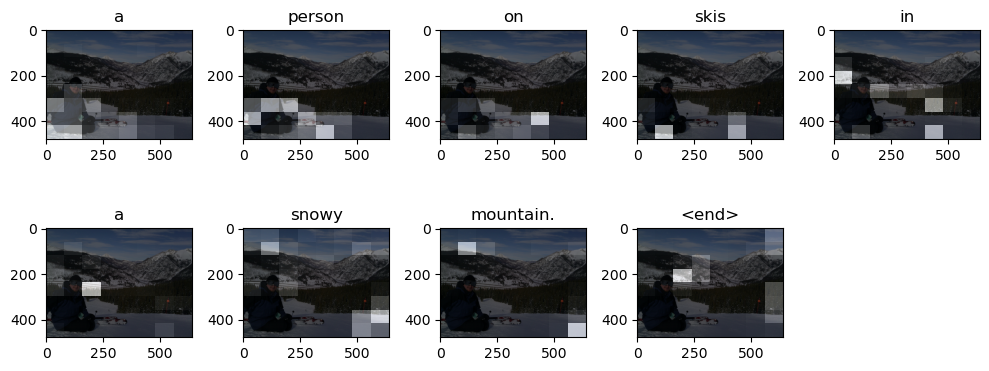

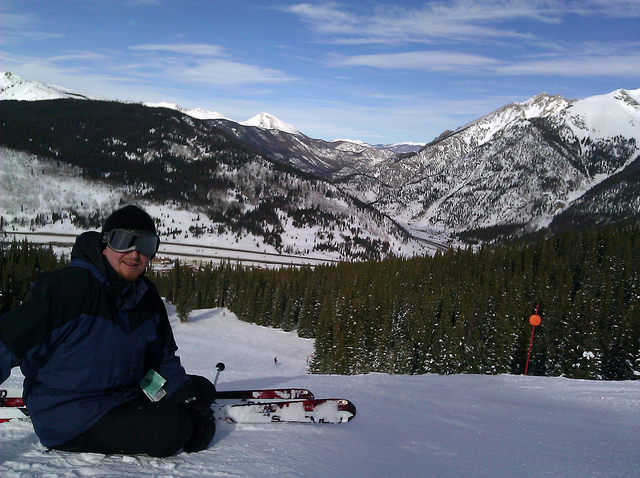

In [97]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

Image.open(img_name_val[rid])

Ce code permet de tester un exemple d'image sur le modèle entraîné. Il définit d'abord un répertoire "test_folder" qui contient les images de test, puis il récupère toutes les images de ce répertoire dans la liste "test_images". Ensuite, il choisit une image aléatoire dans cette liste d'images de test et l'enregistre dans la variable "image". 

Il utilise ensuite la fonction "evaluate" pour prédire une légende pour cette image, enregistrant le résultat et le plot d'attention dans les variables "result" et "attention_plot" respectivement. 

Il affiche ensuite la prédiction de la légende en utilisant la fonction "plot_attention" pour visualiser le plot d'attention et l'image elle-même.





Prediction Caption: a tennis player getting ready to hit the tennis ball. <end>


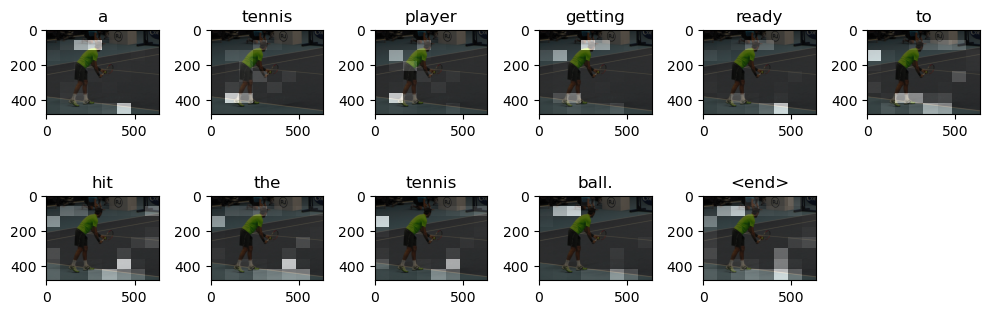

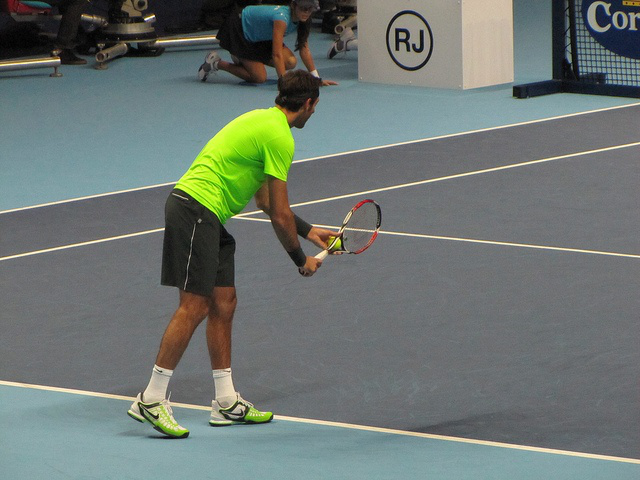

In [146]:
test_folder = './test/Dataset'

test_images = os.listdir(test_folder)

test_images = [os.path.join(test_folder, image) for image in test_images]

rid = np.random.randint(0, len(test_images))

image = test_images[rid]

result, attention_plot = evaluate(image)

print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(image)

Prediction Caption: the surfer in the top of a wave. <end>


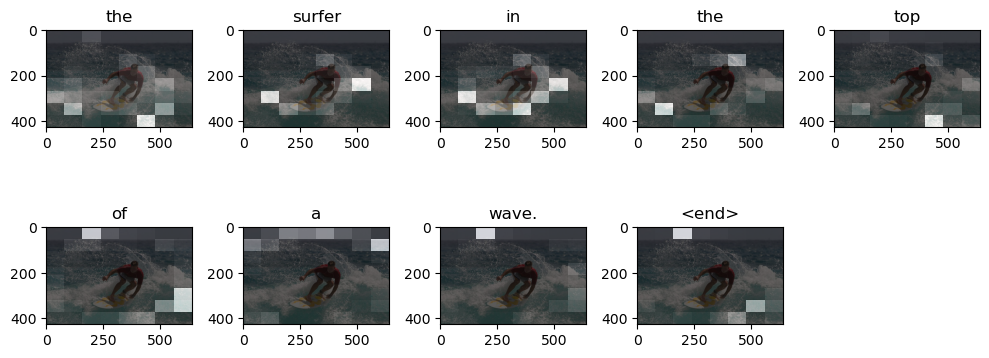

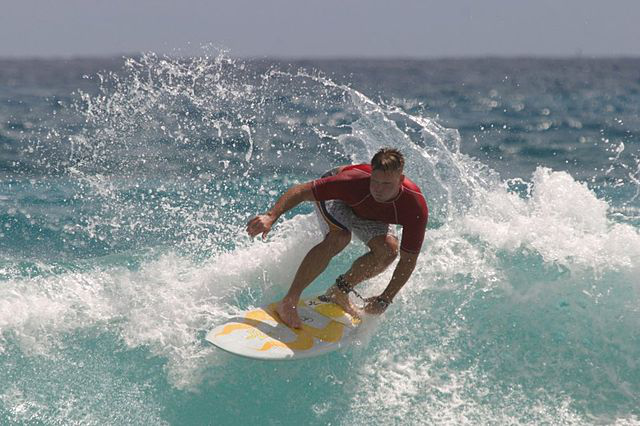

In [147]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [148]:
# # # save the model to use it later without training it again
# model_encoder_file = 'captioning_model_encoder_with_attention' + f"_{datetime.datetime.now():%Y%m%d_%H%M%S}" + ".h5"
    
# model_decoder_file = 'captioning_model_decoder_with_attention' +  f"_{datetime.datetime.now():%Y%m%d_%H%M%S}"  + ".h5"
   
# model_folder = './models_best_fits/'

# model_encoder_path = os.path.join(model_folder, model_encoder_file)
# model_decoder_path = os.path.join(model_folder, model_decoder_file)

# encoder.save(model_encoder_path)
# decoder.save(model_decoder_path)
